# Random Dataset Generator

Usually the data will be provided or atleast accesible for the data engineer. For this project, I wanted to focus on creating data pipelines for online education analytics. Being that I'm enrolled in an online education program, I was hoping to access Udacity data for this project. Although after asking the udacity support team, the politely declined my request. As for plan b, I decided to create my own synthetic numerical data and use public accesible text data.  Given that this project revolves around the data pipeline process, data integrity isn't as important. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import itertools
from faker import Faker
import datetime
import os
import glob
import datetime as dt

In [114]:
def generate_skewed_list(mean, std, n_quantiles, pop, min_val=0, max_val=None):
    quantiles_list = np.arange(min_val, n_quantiles)
    prob = ss.norm.pdf(quantiles_list, loc=mean, scale=std)
    prob = prob / prob.sum()
    nums = np.random.choice(quantiles_list, size=pop, p=prob)
    if max_val != None:
        nums = np.where(nums < max_count, nums, max_count)
    else:
        pass
    plt.hist(nums)
    plt.show()
    return nums

In [3]:
users = 50000
videos = 3
sections = 3
projects = 3
nanodegrees = 3
start_date = dt.date(year=2019, month=1, day=1)
end_date = dt.date(year=2019, month=12, day=31)

# Video Log

Dataset:
- user_id
- video_id (27 unique video IDs)
- views


Data science 2/5

Data analyst 1/2

Data Engineer 1/10

## Create Video, Section and Nano Degree IDs

In [5]:
def generate_ids(id_count, start_id, end_id, degree_id, sections):
    video_array = []
    degree_array = []
    user_id = 0
    while user_id != id_count:
        video_array.extend(np.arange(start_id, end_id))
        degree_array.extend([degree_id] * sections)
        user_id += 1
    return video_array, degree_array

In [6]:
ds_ids, ds_degree_ids = generate_ids(20000, 1, 4, 1, 3)
da_ids, da_degree_ids = generate_ids(25000, 3, 6, 2, 3)
de_ids, de_degree_ids = generate_ids(5000, 5, 8, 3, 3)

video_array = ds_ids + da_ids + de_ids
nano_degree_array = ds_degree_ids + da_degree_ids + de_degree_ids

## Create User IDs

In [7]:
user_id = 0
video_user_array = []
while user_id != users:
    user_id += 1
    video_user_array.extend([user_id]*3)


## Create Video Views 

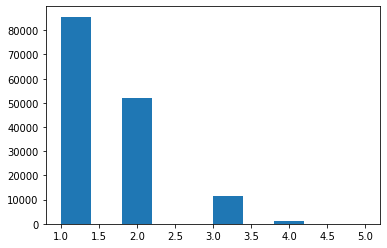

In [8]:
views_per_user = generate_skewed_list(mean=1, std=1, n_quantiles=100, pop=150000, min_val=1)

## Compile Video Log Dataframe

In [12]:
one_degree_video_log = pd.DataFrame(columns=['user_id', 'video_id', 'degree_id', 'views_per_user'])
one_degree_video_log['video_id'] = video_array
one_degree_video_log['user_id'] = video_user_array
one_degree_video_log['views_per_user'] = views_per_user
one_degree_video_log['degree_id'] = nano_degree_array

In [13]:
def generate_ids_multiple_degrees(df, degree_ids, videos):
    degree_to_section_dict = {1: np.arange(1,4), 2: np.arange(3,6), 3: np.arange(5,8)}
    video_array = []
    degree_array = []
    user_array = []
    for user in degree_ids:
        # get degree id from first degree log dataset
        current_degree = df[df['user_id'] == user]['degree_id'].unique()[0]
        # picks whether user has 1 or 2 extra degrees 
        num_next_degrees = np.random.choice([1,2], size=1, p=[.7, .3])[0]
        # gets extra degrees' id
        all_degree_ids = [1,2,3]
        all_degree_ids.remove(current_degree)
        next_degrees = np.random.choice(all_degree_ids, size=num_next_degrees)
        # adds video ids for each extra degree to nested list
        next_videos = [degree_to_section_dict[degree].tolist() for degree in next_degrees]
        # flattens nested list
        video_array.extend(list(itertools.chain.from_iterable(next_videos)))
        # adds x duplicates of the user id to array (depends on number of extra degrees)
        user_array.extend([user] * videos * num_next_degrees)
        # adds x duplicates of degree ids to array (depends on number of extra degrees)
        degree_list = [[degree] * videos for degree in next_degrees]
        # flatten nested list
        degree_array.extend(list(itertools.chain.from_iterable(degree_list)))
    return video_array, degree_array, user_array

In [14]:
multiple_degrees = np.random.choice(np.arange(1,users), size=int(users/5))
video_array_2, degree_array_2, user_array_2 = generate_ids_multiple_degrees(one_degree_video_log, multiple_degrees, videos)


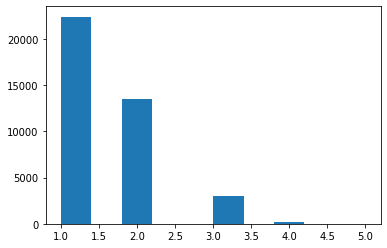

In [15]:
multiple_degrees_video_log = pd.DataFrame(columns=['user_id', 'video_id', 'degree_id', 'views_per_user'])
multiple_degrees_video_log['video_id'] = video_array_2
multiple_degrees_video_log['degree_id'] = degree_array_2
multiple_degrees_video_log['user_id'] = user_array_2
multiple_degrees_count = len(multiple_degrees_video_log)
multiple_degrees_video_log['views_per_user'] = generate_skewed_list(mean=1, std=1, n_quantiles=100, pop=multiple_degrees_count, min_val=1)


In [16]:
video_log_df = one_degree_video_log.append(multiple_degrees_video_log, sort=False).reset_index(drop=True)
video_log_df.head()

,user_id,video_id,degree_id,views_per_user
0,1,1,1,1
1,1,2,1,3
2,1,3,1,1
3,2,1,1,2
4,2,2,1,2


In [17]:
def generate_last_view_date(df, end_date):
    if df['views_per_user'] == 1:
        last_view_date = fake.date_between(start_date=df.first_view_date, end_date=df.first_view_date)
    else:
        last_view_date = fake.date_between(start_date=df.first_view_date, end_date=end_date)
    return last_view_date

In [18]:
def generate_fake_dates(start_date, end_date, n_dates):
    date_list = []
    for i in range(n_dates):
        random_date = pd.to_datetime(fake.date_between(start_date=start_date, end_date=end_date))
        date_list.append(random_date)
    return date_list

In [19]:
fake = Faker()

video_log_df['first_view_date'] = generate_fake_dates(start_date, end_date, len(video_log_df))
video_log_df['last_view_date'] = pd.to_datetime(video_log_df.apply(lambda df: generate_last_view_date(df, end_date), axis=1))
                                                

In [22]:
video_log_df.head()

,user_id,video_id,degree_id,views_per_user,first_view_date,last_view_date
0,1,1,1,1,2019-06-05,2019-06-05
1,1,2,1,3,2019-10-25,2019-12-23
2,1,3,1,1,2019-11-23,2019-11-23
3,2,1,1,2,2019-10-13,2019-10-16
4,2,2,1,2,2019-11-23,2019-11-28


In [23]:
degree_dict = {'data_science': 1, 'data_analytics': 2, 'data_engineering': 3}

final_log_columns = ['user_id', 'video_id', 'degree_id', 'first_view_date', 'last_view_date', 'views_per_user']
for degree, degree_id in degree_dict.items():
    for month in range(1,13):
        log = video_log_df.loc[
                                 (video_log_df['last_view_date'].dt.year == end_date.year) &
                                 (video_log_df['last_view_date'].dt.month == month) & 
                                 (video_log_df['degree_id'] == degree_id)
                              ][final_log_columns].copy().reset_index(drop=True)
        log.to_json(f'data/{degree}/{end_date.year}/{month}/video_log.json')
    print(f'Exporting Done: {degree}')


Exporting Done: data_science
Exporting Done: data_analytics
Exporting Done: data_engineering


# Project and Section Feedback

In [33]:
chunks = pd.read_json('raw_data/yelp_academic_dataset_review.json', lines=True, chunksize=10000)

def json_to_dataframe(chunks, max_count):
    chunk_list = []
    count = 0
    for chunk in chunks:
        count += 10000
        if count % 100000 == 0:
            print('count: ' + str(count))
        chunk = chunk['text']
        chunk_list.append(chunk)
        
        if count >= max_count:
            print('Creating dataframe')
            df = pd.concat(chunk_list)
            return df
# max count needs to be double the video log count to split unique text rows between section and project dataframes
max_count = len(video_log_df) * 2
text_df = json_to_dataframe(chunks, max_count)

count: 100000
count: 200000
count: 300000
Creating dataframe


In [34]:
feedback_df = video_log_df[['user_id', 'video_id', 'degree_id']].copy()
feedback_df_count = len(feedback_df)

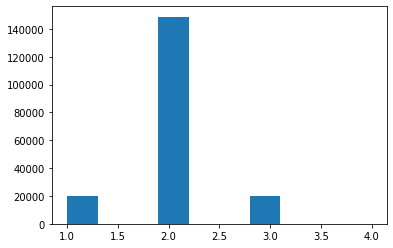

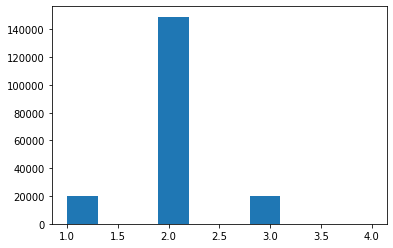

In [121]:
section_df = feedback_df.reset_index(drop=True).join(text_df[:feedback_df_count], lsuffix='_caller', rsuffix='_other')
section_df = section_df.rename(columns={'video_id': 'section_id'})
section_df['rating'] = generate_skewed_list(mean=2, std=.5, n_quantiles=100, pop=feedback_df_count, min_val=1, max_val=3)
section_df['rating'] = section_df['rating'].apply(lambda x: 3 if x > 3 else x)

project_df = feedback_df.reset_index(drop=True).join(text_df[feedback_df_count:].reset_index(drop=True), lsuffix='_caller', rsuffix='_other')
project_df = project_df.rename(columns={'video_id': 'project_id'})
project_df['rating'] = generate_skewed_list(mean=2, std=.5, n_quantiles=100, pop=feedback_df_count, min_val=1, max_val=3)
project_df['rating'] = project_df['rating'].apply(lambda x: 3 if x > 3 else x)


In [127]:
project_df['submit_date'] = generate_fake_dates(start_date, end_date, len(project_df))
section_df['submit_date'] = generate_fake_dates(start_date, end_date, len(section_df))

In [129]:
project_df.head()

,user_id,project_id,degree_id,text,rating,submit_date
0,1,1,1,Quite happy with this find. Have driven past t...,2,2019-05-23
1,1,2,1,"The food was outstanding, service was excellen...",1,2019-04-04
2,1,3,1,Great place to hang out and have a cocktail an...,2,2019-05-16
3,2,1,1,Usually one of our reliable stand by restauran...,2,2019-12-06
4,2,2,1,DO NOT GET DIRECT TV!!! They lie about so much...,2,2019-04-09


In [132]:
degree_dict = {'data_science': 1, 'data_analytics': 2, 'data_engineering': 3}

def export_project_and_section_feedback(df, parent_dir, export_columns, degree_dict, year_filter):
    for degree, degree_id in degree_dict.items():
        for month in range(1,13):
            partitioned_data = df.loc[
                                     (df['submit_date'].dt.year == year_filter) &
                                     (df['submit_date'].dt.month == month) & 
                                     (df['degree_id'] == degree_id)
                                  ][export_columns].copy().reset_index(drop=True)

            partitioned_data.to_json(f'data/{degree}/{year_filter}/{month}/{parent_dir}.json')
        print(f'Exporting Done: {degree}')

In [133]:
final_project_columns = ['user_id', 'project_id', 'submit_date', 'text', 'rating']
export_project_and_section_feedback(project_df, 'project_feedback', final_project_columns, degree_dict, 2019)


Exporting Done: data_science
Exporting Done: data_analytics
Exporting Done: data_engineering


In [134]:
final_section_columns = ['user_id', 'section_id', 'submit_date', 'text', 'rating']
export_project_and_section_feedback(section_df, 'section_feedback', final_section_columns, degree_dict, 2019)


Exporting Done: data_science
Exporting Done: data_analytics
Exporting Done: data_engineering


In [ ]:

bucket =  s3.Bucket("udacity-de-capstone")
client = boto3.client('s3', aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET)

for obj in bucket.objects.all():
    if obj.key.endswith('.json'):
        file_name = re.findall(pattern='[^/]*$', string=obj.key)[0]
        file_key = re.findall(pattern='^.+/', string=obj.key)[0]
        print()
        print(f'old file name: {file_name}')
        print(f'file key: {file_key}')
        s3.Bucket('udacity-de-capstone').download_file(obj.key, file_name)
        if file_name.split('.')[0] == 'mentor_activity':
            try:
                df = pd.read_json(file_name, lines=True)
            except Exception as e:
                print(e)
        else:
            df = pd.read_json(file_name)
        new_file_name = file_name.replace('.json', '.csv')
        df.to_csv(file_key+new_file_name, header=True, index=False)
        # client = boto3.client('s3', aws_access_key_id=KEY,
        #                aws_secret_access_key=SECRET)
        # response = client.upload_file(new_file_name, 'udacity-de-capstone', file_key)
        print(f'new csv: {file_key+new_file_name}')
        os.remove(file_name)
    else:
        pass